In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.visualization import plot_bloch_multivector, plot_state_qsphere
import qiskit.quantum_info as qi
from utils import print_statevector

# Generating Multi-Qubit $W$ States in Qiskit


## Introduction <a id="intro"></a>

This notebook presents a step-by-step explanation on how to implement n-qubit $W$ states in Qiskit. A compact function that takes the number of qubits `n` as an argument and returns a `QuantumCircuit` to generate the $W$ state is derived.

In the first section, we go over each of the steps of the process by looking at a 4-qubit [example](#example). This example contains a lot of details, so the necessary steps are summarized for the general n-qubit case under the [general methodology](#general) section. Then, we present the [code implementation](#code) of the algortihm. Lastly, a few [final notes](#final) on other possible implementations are discussed and the code is also provided.

For more info on what $W$ states are, you can refer to this [wikipedia page](https://en.wikipedia.org/wiki/W_state). You can also learn about some of the advantages $W$ states have over $GHZ$ states in this [IBMQ document](https://quantum-computing.ibm.com/docs/iqx/guide/entanglement) on entanglement. It is worth mentioning that the procedure I developed to generate generic n-qubit $W$ states was inspired by the 3-qubit circuit presented at the end of that document, but for which no explanation was provided. So if you don't know about $W$ states, go check out those resources and come back here to learn how to implement them!

## Procedure <a id="procedure"></a>

The idea is to come up with an algorithm that generates a quantum circuit $U_W$ that takes an $n$-qubit zero-state: $| 0 \rangle^{\otimes n} = |0 \dots 00 \rangle $, and evolves it into an $n$-qubit $W$ state of the form:

$$
| W_n \rangle = \frac{1}{\sqrt{n}} \left ( | 0\dots 01 \rangle + | 0\dots 10 \rangle + \dots + | 1\dots 00 \rangle \right ) 
$$

To better understand what the algorithm should do, let's firts look at an example with a relatively small number of qubits, and then define the general steps to follow for n-qubits.

### Example: Generating a 4-qubit $W$ state <a id="example"></a>

Our goal is to compose a circuit that generates the state:

$$ | W_4 \rangle = \sqrt{\frac{1}{4}} \left( | 0001 \rangle + | 0010 \rangle + | 0100 \rangle + | 1000 \rangle \right ) $$

To do this, we will break the process into two main steps: 

1) Probability redistribution, and 

2) State reshuffling. 

The meaning of these steps will become evident once we go over the details.

#### Probability Redistribution <a id="prob_res"></a>

As per usual, we begin with our state initialized in the all-zeros state:

$$|\psi_0 \rangle = | 0000 \rangle, $$

where our qubit numbering is in the form: $| q_3 q_2 q_1 q_0 \rangle$. What we will like to do is to start evolving this state into a superposition of elements where, step by step, we add a new component that has the same probability amplitude of our final state: $\sqrt{1/n}$. 

So, the first step is to place our state in a superposition of two elements, where one of them has the probability amplitude we want for the final state; in this case: $\sqrt{1/4}$. Since the probabilities must add up to 1, the second component has to have a probability amplitude $\sqrt{3/4}$, so our state has to be of the form:

$$|\psi_1 \rangle = \sqrt{\frac{1}{4}}| 0000 \rangle + \sqrt{\frac{3}{4}}| 0001 \rangle,$$

which we can also rewrite by separating the least significant qubit:

$$
|\psi_1 \rangle = | 000\rangle \otimes \left[ \sqrt{\frac{1}{4}}| 0 \rangle + \sqrt{\frac{3}{4}}| 1 \rangle \right ]
$$

If we take a step back, and focus on how we would evolve the least-significant qubit of $|\psi_0 \rangle$ from state $|0 \rangle$ to state $\sqrt{1/4}| 0 \rangle + \sqrt{3/4}| 1 \rangle $, it is not too difficult to realize that this can be done by rotating the qubit about the y-axis of the Bloch sphere in a way that we obtain the desired probability amplitudes. For this, we use an $R_y(\theta_0)$ gate, which has the following unitary:

$$ 
R_y(\theta) = \begin{pmatrix} \cos{\left(\frac{\theta}{2}\right)} & \text{-}\sin{\left(\frac{\theta}{2}\right)} \\ \sin{\left(\frac{\theta}{2}\right)} & \cos{\left(\frac{\theta}{2}\right)} \end{pmatrix}
$$

So, evolving the state $|\psi_0 \rangle = | 000 \rangle \otimes | 0 \rangle $ through the unitary $R_y(\theta_0)$ applied on $q_0$ results in the state:

$$
|\psi_1 \rangle = |000\rangle \otimes \left [ \cos{\left(\frac{\theta_0}{2}\right)}| 0 \rangle + \sin{\left(\frac{\theta_0}{2}\right)}| 1 \rangle \right ]
$$

We can now find the rotation angle needed for the gate $\theta_0$ by equating the probability amplitude for the $| 0 \rangle $ component inside the square brackets, with the desired probability amplitude of $\sqrt{1/4}$:

$$ 
\begin{aligned}
& \cos{\left(\frac{\theta_0}{2}\right)} = \sqrt{\frac{1}{4}} 
\\
& \theta_0 = 2 \cos^{\text{-}1}{\left(\sqrt{\frac{1}{4}}\right)}
\\
& \theta_0 = \frac{2\pi}{3} \text{ rad}
\end{aligned}
$$

It is worth noting that equating the $|1 \rangle $ terms: $\sin{(\theta_0/2)} = \sqrt{3/4}$, and solving for $\theta_0$, obviously yields the same result.

Let's try that out in Qiskit and see what we get:

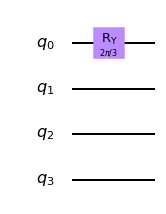

In [2]:
n = 4                             # Number of qubits
prob_amp = np.sqrt(1/n)           # Probability amplitudes of the final W state
theta_0 = 2*np.arccos(prob_amp)   # Rotation angle for Ry gate to place state in superposition with desired prob amp

qc_w4 = QuantumCircuit(n)
qc_w4.ry(theta_0,0)
qc_w4.draw('mpl')

Now, let's check the resultant state from this circuit:

In [3]:
psi_1 = qi.Statevector.from_instruction(qc_w4)
print_statevector(psi_1.data, pretext="| \psi_{1} \\rangle = ")

<IPython.core.display.Math object>

Since $\sqrt{1/4} = 1/2$, we have confirmed this rotation yields the expected superposition state.

What we will like to do next is, bring in a second element to our total state that also has the same final probability amplitude of $\sqrt{1/4}$. Another way of looking at this is to think of this process as redistributing the probability amplitude $\sqrt{3/4} $ of state $|0001 \rangle $ between two new components. One component will have the desired amplitude of $\sqrt{1/4}$, and the second one a probability amplitude of $\sqrt{2/4}$. 

A very nice way this can be done is by the use of the controlled rotation gate $CR_y(\theta)$. This gate works like any other controlled gate: 
   1. If the control qubit $q_c$ is zero, the target qubit $q_t$ is left unchanged
   2. If the control qubit $q_c$ is one, the target qubit $q_t$ is evolved through the gate $R_y(\theta)$

For example:
$$
\begin{aligned}
&|q_t q_c\rangle = |00\rangle \xrightarrow[]{CR_y(\theta)} |00\rangle
\\
\\
&|q_t q_c\rangle = |01\rangle \xrightarrow[]{CR_y(\theta)} \cos{\left(\frac{\theta}{2}\right)}| 01 \rangle + \sin{\left(\frac{\theta}{2}\right)}| 11 \rangle 
\end{aligned}
$$

So, rewriting $|\psi_1\rangle$ (from above) as:

$$
|\psi_1 \rangle = |00\rangle \otimes \left[ \sqrt{\frac{1}{4}}| 00 \rangle + \sqrt{\frac{3}{4}}| 01 \rangle \right ]
$$

And applying a $CR_y(\theta_1)$ gate between qubits $q_0$ and $q_1$ (terms inside square brakets) we get:

$$
|\psi_2 \rangle = |00\rangle \otimes \left [ \sqrt{\frac{1}{4}}| 00 \rangle + \sqrt{\frac{3}{4}} \left ( \cos{\left(\frac{\theta_1}{2}\right)}| 01 \rangle + \sin{\left(\frac{\theta_1}{2}\right)}| 11 \rangle \right ) \right ]
$$

So, as we did before, we can take the probability amplitude accompanying the $|01 \rangle$ term inside the square brackets, and equate it to the desired final probability amplitude of $\sqrt{1/4}$:

$$ 
\begin{aligned}
& \sqrt{\frac{3}{4}} \cos{\left(\frac{\theta_1}{2}\right)} = \sqrt{\frac{1}{4}} 
\\
& \theta_1 = 2 \cos^{\text{-}1}{\left(\sqrt{\frac{1}{3}}\right)}
\\
& \theta_1 \approx 1.91 \text{ rad}
\end{aligned}
$$


Replacing $\theta_2$ in $|\psi_2\rangle$, the resulting state then is:

$$
|\psi_2 \rangle = \sqrt{\frac{1}{4}}| 0000 \rangle + \sqrt{\frac{1}{4}}| 0001 \rangle + \sqrt{\frac{2}{4}}| 0011 \rangle
$$

Once again, let's check if by adding this gate to our circuit in Qiskit we get the expected state:

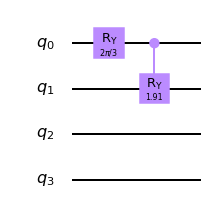

In [4]:
comp_amp = np.sqrt(1-1/n)                    # Complementary probability amplitude after first Ry gate
theta_1 = 2*np.arccos(prob_amp/(comp_amp))   # Rotation angle for first CRy gate
qc_w4.cry(theta_1,0,1)
qc_w4.draw('mpl')

In [5]:
psi_2 = qi.Statevector.from_instruction(qc_w4)
print_statevector(psi_2.data, pretext="| \psi_{2} \\rangle = ")

<IPython.core.display.Math object>

And, since $\sqrt{1/4} = 1/2$ and $\sqrt{2/4} = 1/\sqrt{2}$, we have confirmed our circuit returned the expected state.

Now, not surprisingly, for the next qubit we just need to repeat the previous step: redistribute the probability of $\sqrt{2/4}$ accompanying $|0011\rangle$ by applying a $CR_y(\theta_2)$ gate between qubits $q_1$ and $q_2$:

$$
|\psi_3 \rangle = \sqrt{\frac{1}{4}}| 0000 \rangle + \sqrt{\frac{1}{4}}| 0001 \rangle + \sqrt{\frac{2}{4}} \left( \cos{\left(\frac{\theta_2}{2}\right)}| 0011 \rangle + \sin{\left(\frac{\theta_2}{2}\right)}| 0111 \rangle \right ),
$$

and equate the $\cos$ term with the final probability amplitude of $\sqrt{1/4}$:

$$ 
\begin{aligned}
& \sqrt{\frac{2}{4}} \cos{\left(\frac{\theta_2}{2}\right)} = \sqrt{\frac{1}{4}} 
\\
& \theta_2 = 2 \cos^{\text{-}1}{\left(\sqrt{\frac{1}{2}}\right)}
\\
& \theta_2 = \frac{\pi}{2} \text{ rad}
\end{aligned}
$$


Replacing $\theta_2$ in $|\psi_3\rangle$, the resulting state then is:

$$
|\psi_3 \rangle = \sqrt{\frac{1}{4}}| 0000 \rangle + \sqrt{\frac{1}{4}}| 0001 \rangle + \sqrt{\frac{1}{4}}| 0011 \rangle + \sqrt{\frac{1}{4}}| 0111 \rangle
$$

Again, let's add this gate in Qiskit:

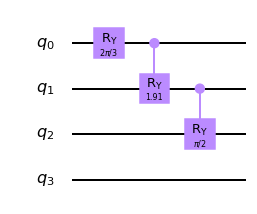

In [6]:
comp_amp = np.sqrt(1-2/n)                    # Complementary probability amplitude after second Ry gate
theta_2 = 2*np.arccos(prob_amp/(comp_amp))   # Rotation angle for first CRy gate
qc_w4.cry(theta_2,1,2)
qc_w4.draw('mpl')

In [7]:
psi_3 = qi.Statevector.from_instruction(qc_w4)
print_statevector(psi_3.data, pretext="| \psi_{3} \\rangle = ")

<IPython.core.display.Math object>

Great! Now we have a state in a superposition of four components all with the desired probability amplitude of the $W_4$ state: $\sqrt{1/4} = 1/2$. However, the components we ended up with are not exactly the ones we wanted, so we need to find a way to reshuffle them.

#### State Reshuffling <a id="state_res"></a>

To better understand how we can reorganize our superposition components, let's revist each of the states we generated throughout the "probability redistribution" step:

$$
\begin{aligned}
&|\psi_0 \rangle = \sqrt{\frac{4}{4}}| 0000 \rangle
\\
&|\psi_1 \rangle = \sqrt{\frac{1}{4}}| 0000 \rangle + \sqrt{\frac{3}{4}}| 0001 \rangle 
\\
&|\psi_2 \rangle = \sqrt{\frac{1}{4}}| 0000 \rangle + \sqrt{\frac{1}{4}}| 0001 \rangle + \sqrt{\frac{2}{4}}| 0011 \rangle
\\
&|\psi_3 \rangle = \sqrt{\frac{1}{4}}| 0000 \rangle + \sqrt{\frac{1}{4}}| 0001 \rangle + \sqrt{\frac{1}{4}}| 0011 \rangle + \sqrt{\frac{1}{4}}| 0111 \rangle
\end{aligned}
$$

As can be seen, after each step, not only we redistributed the probability amplitude between two new components but, each extra new component we added had an additional qubit flipped from state $0$ to state $1$. A way like to think about this is that after each step we "turned on" an extra qubit, so now we need to "turn off" those we don't want in state $1$.

Before we start doing this, it is important to note that actually there is no component where qubit $q_3$ is in state $1$. If we were to use an $X$ gate of $q_3$ that will flip the state in all components of the superposition, which is not desirable. So, a way to flip it in only one component would be to apply a $CNOT$ gate with $q_2$ as the control and $q_4$ as the target, resulting in:

$$
|\psi_4 \rangle = \sqrt{\frac{1}{4}}| 0000 \rangle + \sqrt{\frac{1}{4}}| 0001 \rangle + \sqrt{\frac{1}{4}}| 0011 \rangle + \sqrt{\frac{1}{4}}| \underset{\substack{\uparrow}}{1}111 \rangle
$$

In Qiskit:

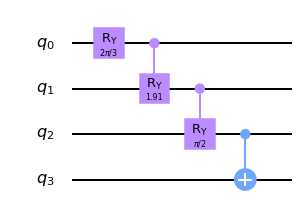

In [8]:
qc_w4.cx(2,3)
qc_w4.draw('mpl')

In [9]:
psi_4 = qi.Statevector.from_instruction(qc_w4)
print_statevector(psi_4.data, pretext="| \psi_{4} \\rangle = ")

<IPython.core.display.Math object>

And, just as we used a $CNOT$ to "turn on" $q_3$ for only one superposition component, we can use $CNOT$s to "turn off" qubits by "re-shuffling" them one by one. So, a $CNOT$ with $q_1$ as control and $q_2$ as target we get:

$$
|\psi_5 \rangle = \sqrt{\frac{1}{4}}| 0000 \rangle + \sqrt{\frac{1}{4}}| 0001 \rangle + \sqrt{\frac{1}{4}}| 0\underset{\substack{\uparrow}}{1}11 \rangle + \sqrt{\frac{1}{4}}| 1\underset{\substack{\uparrow}}{0}11 \rangle,
$$

($q_2$ was turned off in the last component, and turned on in the second-to-last component). 

Then, a $CNOT$ with $q_0$ as control and $q_1$ results in:

$$
|\psi_6 \rangle = \sqrt{\frac{1}{4}}| 0000 \rangle + \sqrt{\frac{1}{4}}| 00\underset{\substack{\uparrow}}{1}1 \rangle + \sqrt{\frac{1}{4}}| 01\underset{\substack{\uparrow}}{0}1 \rangle + \sqrt{\frac{1}{4}}| 10\underset{\substack{\uparrow}}{0}1 \rangle,
$$

($q_1$ was turned off in the last two components, and turned on in the second component). Lastly, an $X$ gate in $q_0$ gives us the desired state:

$$
|W_4 \rangle = \sqrt{\frac{1}{4}}| 000\underset{\substack{\uparrow}}{1} \rangle + \sqrt{\frac{1}{4}}| 001\underset{\substack{\uparrow}}{0} \rangle + \sqrt{\frac{1}{4}}| 010\underset{\substack{\uparrow}}{0} \rangle + \sqrt{\frac{1}{4}}| 100\underset{\substack{\uparrow}}{0} \rangle,
$$

($q_0$ was turned off in the last three components, and turned on in the first component)

Adding these gates to our Qiskit circuit:

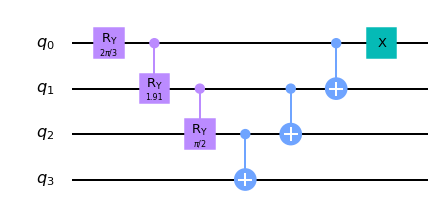

In [10]:
qc_w4.cx(1,2)
qc_w4.cx(0,1)
qc_w4.x(0)
qc_w4.draw('mpl')

In [11]:
W_4 = qi.Statevector.from_instruction(qc_w4)
print_statevector(W_4.data, pretext="| W_{4} \\rangle = ")

<IPython.core.display.Math object>

And were done! 

Since there were a lot of details throughout this explanation, it might not have been completely obvious that this method can be generalized for n-qubits, so let's look at the steps we need to follow to algorithmically generate a circuit for n-qubit $W$ states.

## General Methodology <a id="general"></a>

The steps taken to generate a $W$ state with an arbitrary number of qubits $|q_{n-1} \dots q_1 q_0 \rangle $ are:

1. Compute the probability amplitude $w$ and the complementary probability amplitude $\bar w$:

    $$ w = \sqrt{\frac{1}{n}} \quad \text{and} \quad \bar w = \sqrt{1 - \frac{1}{n}} $$


2. Calculate the angle $\theta_0$:

    $$ 
    \theta_0 = 2 \cos^{\text{-}1} \left ( \frac{w}{\bar w} \right ) = 2 \cos^{\text{-}1} \left ( \sqrt{\frac{1}{n-1}} \right ) 
    $$
    

3. Apply an y-rotation gate $R_y(\theta_0)$ on $q_0$ such that we get the superposition state:

    $$ \sqrt{\frac{1}{n}} | 0 \dots 00 \rangle + \sqrt{1 - \frac{1}{n}} | 0 \dots 01 \rangle $$
    

**Steps 4 thru 6 should be sequentially repeated from $i = 2$ to $i = (n - 1)$**

4. Recompute the complementary probability amplitude $\bar w$ as:

    $$ \bar w = \sqrt{1 - \frac{i}{n}} $$


5. Calculate the angle $\theta_{i-1}$:

    $$ 
    \theta_{i-1} = 2 \cos^{\text{-}1} \left ( \frac{w}{\bar w} \right ) = 2 \cos^{\text{-}1} \left ( \sqrt{\frac{1}{i-n}} \right ) 
    $$


6. Perform a controlled y-rotation ($CR_y(\theta_{i-1})$ gate) with $q_{i-2}$ as control and $q_{i-1}$ as target, such that we generate the entangled state:

    $$ 
    \sqrt{\frac{1}{n}} | 0 \dots 00 \rangle + \sqrt{\frac{1}{n}} | 0 \dots 01 \rangle + \dots + \sqrt{1 - \frac{i}{n}} | 0 \dots 11 \rangle
    $$


7. Apply a $CNOT$ gate with $q_{n-j-1}$ as the control and $q_{n-j}$ as the target, such that after repeating this from $j = 0$ to $j = (n - 1)$ we end up with the state:

    $$
    \frac{1}{\sqrt{n}} \left ( | 0\dots 00 \rangle + | 0\dots 11 \rangle + \dots + | 1\dots 01 \rangle \right ) 
    $$
    
8. Apply an $X$ gate on $q_0$ so we get the desired state:

    $$
    \frac{1}{\sqrt{n}} \left ( | 0\dots 01 \rangle + | 0\dots 10 \rangle + \dots + | 1\dots 00 \rangle \right ) 
    $$


## Code Implementation <a id="code"></a>

The above methodology can be implemented into compact function as show below.

In [12]:
def w_cir(n):
    
    prob_amp = np.sqrt(1/n)
    rot_ang = 2*np.arccos(prob_amp)
    
    qc_w = QuantumCircuit(n) 
    
    # probability redistribution
    qc_w.ry(rot_ang,0)
    
    for i in range(1,n-1):
        comp_amp = np.sqrt(1-i/n)
        rot_ang = 2*np.arccos(prob_amp/(comp_amp))
        qc_w.cry(rot_ang,i-1,i)
    
    # state reshuffling
    for i in range(n-1, 0, -1):
        qc_w.cx(i-1,i)
    
    qc_w.x(0)
    
    return qc_w

Since we did the derivation for the 4-qubit case, let's try out the function for a larger number of qubits. For the case of 6 qubits, we should get a state in a superposition of 6 elements with probability amplitudes of $1/\sqrt{6} \approx 0.40825$

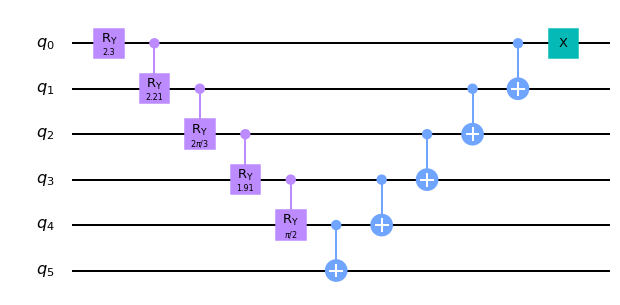

In [13]:
n = 6
qc_w6 = w_cir(n)
qc_w6.draw('mpl')

In [14]:
W_6 = qi.Statevector.from_instruction(qc_w6)
print_statevector(W_6.data, pretext="| W_{6} \\rangle = ")

<IPython.core.display.Math object>

And just for fun, let's plot it in the qsphere

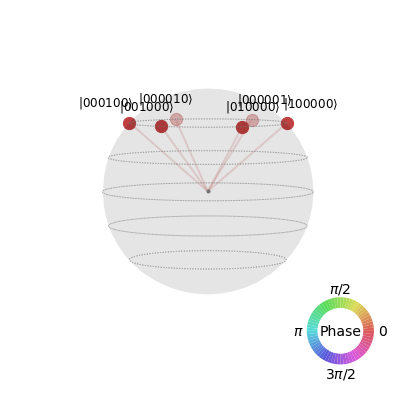

In [15]:
plot_state_qsphere(qi.Statevector.from_instruction(qc_w6))

## Final Notes <a id="final"></a>

Even though I got some clues on how this circuit can be implemented from the [IBMQ document](https://quantum-computing.ibm.com/docs/iqx/guide/entanglement) on entanglement, the rediscovery process of what each component is doing, and how the circuit could be generalized was a lot of fun and educational.

After finalizing this process, I did find a few other resources that explain how these states can be generated. In particular, Craig Gidney's response to this Quantum-Computing [stackexchange question](https://quantumcomputing.stackexchange.com/questions/4350/general-construction-of-w-n-state) seems to follow the same procedure I described here; although I do have to admit that it took me quite some time to figure out what he was trying to say.

Later, I also found this [paper](https://arxiv.org/pdf/1807.05572.pdf) where the process they follow to generate W-states seems more elegant. Instead of first performing the whole probability redistribution and then the whole state reshuffling process, these two steps are done simultaneously on each step. I decided to code this function as well since I found it to be very interesting:

In [16]:
def w_cir2(n):
    
    prob_amp = np.sqrt(1/n)
    rot_ang = 2*np.arccos(prob_amp)
    
    qc_w = QuantumCircuit(n)
    
    qc_w.x(0)
    
    for i in range(0,n-1):
        comp_amp = np.sqrt(1-i/n)
        rot_ang = 2*np.arccos(prob_amp/(comp_amp))
        qc_w.cry(rot_ang,i,i+1)
        qc_w.cx(i+1,i)
    
    return qc_w

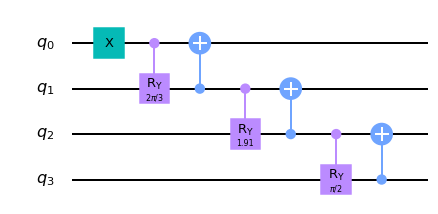

In [17]:
qc2_w4 = w_cir2(4)
qc2_w4.draw('mpl')

In [18]:
W2_4 = qi.Statevector.from_instruction(qc2_w4)
print_statevector(W2_4.data, pretext="| W_{4} \\rangle = ")

<IPython.core.display.Math object>

As can been seen, the resultant $W$ state generated by this circuit is the same as the one generated by the one discussed in this document. An advantage of this architecture is that, as discussed in the paper, it can be slightly modified to reduce the time-complexity (number of gates) from linear ($\mathcal{O} \sim N$) to logarithmic ($\mathcal{O} \sim log_2N$), so check it out!

Thanks for reading,

### DIEGO EMILIO SERRANO